In [130]:
import pandas as pd
import json
import os
import matplotlib.pyplot as plt
import seaborn as sns


# Import english data

In [131]:
file_prompt_mapping = {
    'base_prompt.jsonl': 'base',
    'persona_prompt.jsonl': 'persona',
    'examples_prompt.jsonl': 'examples',
    #'examples_with_cot_prompt.jsonl': 'examples_with_cot',
    'gpt 41 examples prompt.jsonl': 'examples',
    #'gpt 41 examples with cot prompt.jsonl': 'examples_with_cot',
    'o3 examples_prompt.jsonl': 'examples',
    'o3 examples_prompt.jsonl': 'examples',
    'Best combination with persona.jsonl': 'dynamic',
    'examples with_cot_proper_failed_at_35haiku.jsonl': 'examples_with_cot',
    'examples with cot proper rest.jsonl': 'examples_with_cot',
    'grok 3 and 3 mini and o3 mini best best combination with persona.jsonl': 'dynamic',

    
}

base_path = os.getcwd()
data_dir = os.path.join(base_path, "quantitative data")

ignore_models = ['grok-2-1212', 'gpt-4.1-nano-2025-04-14']

all_rows = []
for filename, prompt_style in file_prompt_mapping.items():
    path = os.path.join(data_dir, filename)
    with open(path, 'r', encoding='utf-8') as f:
        for line in f:
            row = json.loads(line)
            row['source_file'] = filename

            if prompt_style == 'dynamic':
                persona = row.get('include_persona', False)
                examples = row.get('include_examples', False)
                cot_examples = row.get('include_cot_examples', False)
                cot_output = row.get('include_cot_output', False)

                styles = []
                if persona:
                    styles.append('persona')
                if examples:
                    styles.append('examples')
                if cot_examples and cot_output:
                    styles.append('examples_with_cot')
                

                row['prompt_style'] = "+".join(styles) if styles else "base"
            else:
                row['prompt_style'] = prompt_style

            all_rows.append(row)

df = pd.DataFrame(all_rows)

if ignore_models:
    df = df[~df['model'].isin(ignore_models)]
    
# Fix incorrect 'is_correct' evaluations due to case sensitivity in string fields
def compare_tickets_case_insensitive(expected, recommended):
    if not isinstance(expected, dict) or not isinstance(recommended, dict):
        return False
    return (
        str(expected.get("name", "")).lower() == str(recommended.get("name", "")).lower()
        and str(expected.get("category", "")).lower() == str(recommended.get("category", "")).lower()
        and expected.get("number_of_zones") == recommended.get("number_of_zones")
    )

# Overwrite 'is_correct' with corrected comparison
df['is_correct'] = df.apply(
    lambda row: compare_tickets_case_insensitive(row['expected_ticket'], row['recommended_ticket']),
    axis=1
)

# Pretty labels for prompt styles
pretty_prompt_labels = {
    'base': 'Base',
    'persona': 'Persona',
    'examples': 'Few-Shot',
    'examples_with_cot': 'Few-Shot with CoT',
    'persona+examples': 'Persona + Few-Shot',
    'persona+examples_with_cot': 'Persona + Few-Shot with CoT'
}

# Pretty labels for model names
pretty_model_labels = {
    'gpt-4o-mini': 'GPT 4o Mini',
    'gpt-4o-2024-11-20': 'GPT 4o',
    'gpt-4.1-2025-04-14': 'GPT 4.1',
    'gpt-4.1-mini-2025-04-14': 'GPT 4.1 Mini',
    'o3-mini': 'o3 Mini',
    'o3': 'o3',
    'claude-3-7-sonnet-20250219': 'Claude 3.7 Sonnet',
    'claude-3-5-haiku-20241022': 'Claude 3.5 Haiku',
    'grok-3-beta': 'Grok 3 Beta',
    'grok-3-mini-beta': 'Grok 3 Mini Beta',
    'gemini-2.0-flash': 'Gemini 2.0 Flash',
    'gemini-2.0-flash-lite' : 'Gemini 2.0 Flash Lite',
    'gemini-2.5-pro-preview-03-25': 'Gemini 2.5 Pro',
    'deepseek-chat': 'DeepSeek Chat',
    'deepseek-reasoner': 'Deepseek Reasoner'
}


plt.rcParams.update({
    "font.size": 12,              # Base text size
    "axes.titlesize": 16,         # Title size
    "axes.labelsize": 14,         # Axis label size
    "xtick.labelsize": 12,        # X tick label size
    "ytick.labelsize": 12,        # Y tick label size
    "legend.fontsize": 12,        # Legend text
    "figure.titlesize": 16        # Figure title size
})



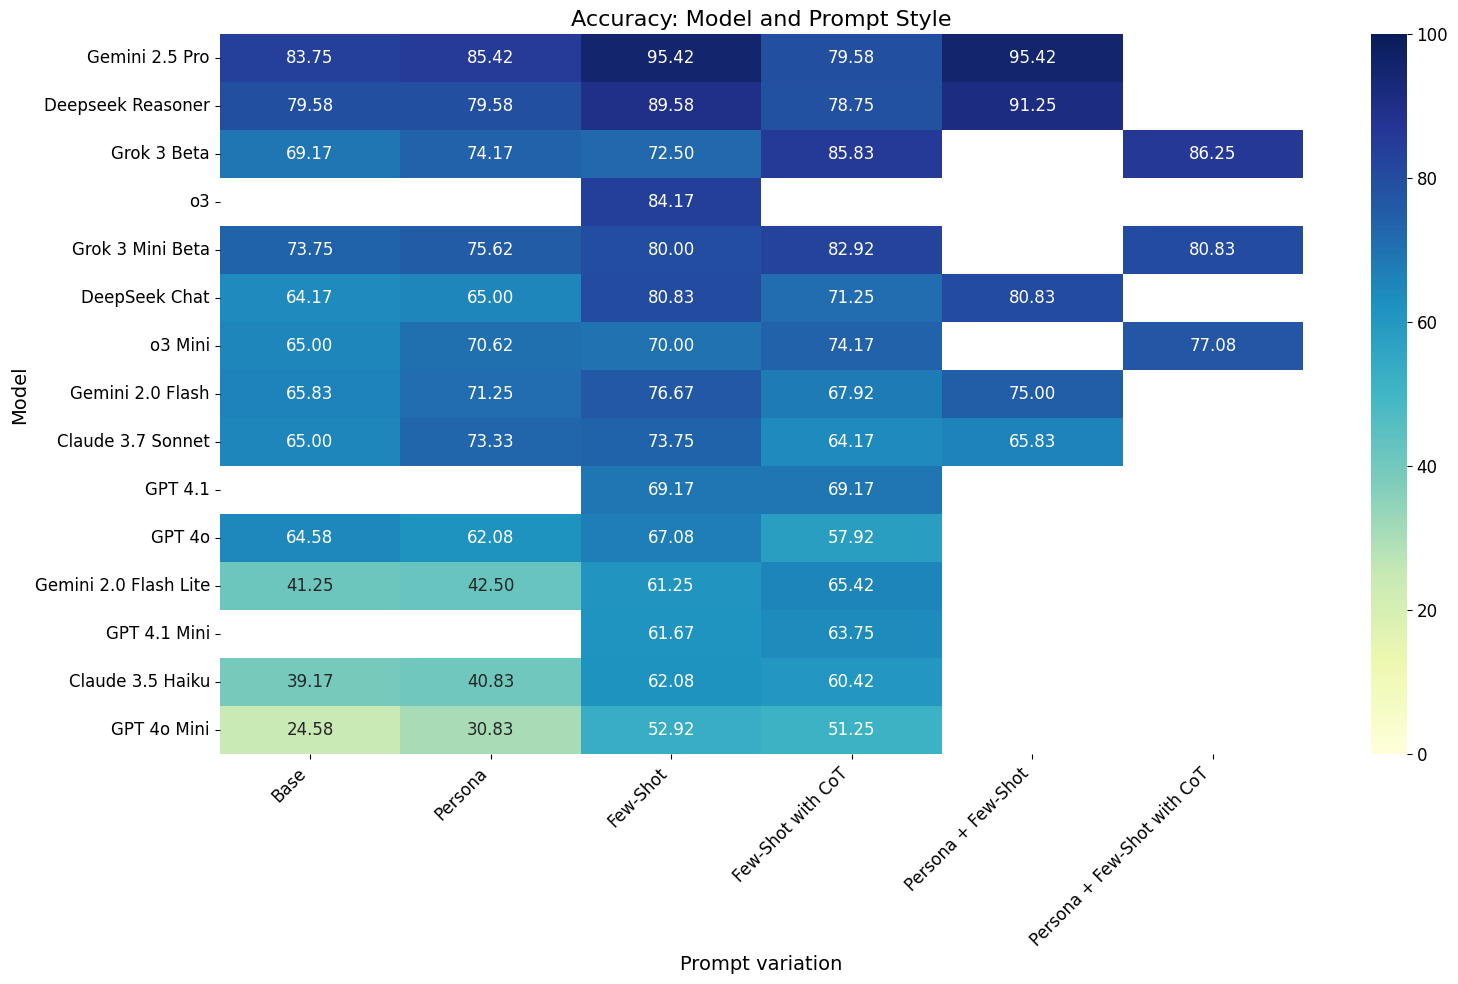

In [132]:

# Define which personas to ignore
ignore_personas = []

# Filter out unwanted personas
filtered_df = df[~df['persona_id'].isin(ignore_personas)]

# Create pivot table with accuracy in percentage
pivot = filtered_df.assign(is_correct_numeric=filtered_df['is_correct'].astype(float) * 100).pivot_table(
    index='model',
    columns='prompt_style',
    values='is_correct_numeric',
    aggfunc='mean'
)

# Sort models by their highest accuracy across prompt styles
pivot['highest_accuracy'] = pivot.max(axis=1)
pivot = pivot.sort_values(by='highest_accuracy', ascending=False).drop(columns=['highest_accuracy'])

# Reorder prompt columns
prompt_order_heatmap = ['base', 'persona', 'examples', 'examples_with_cot',
                        'persona+examples', 'persona+examples_with_cot']
existing_columns = [col for col in prompt_order_heatmap if col in pivot.columns]
pivot = pivot[existing_columns]


# Rename both rows and columns for plotting
pivot_pretty = pivot.rename(columns=pretty_prompt_labels, index=pretty_model_labels)

# Plot heatmap
plt.figure(figsize=(16, 10))
sns.heatmap(pivot_pretty, annot=True, fmt=".2f", cmap="YlGnBu", vmin=0, vmax=100)
plt.title('Accuracy: Model and Prompt Style')
plt.ylabel('Model')
plt.xlabel('Prompt variation')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Export selected models and prompt styles for human evaluation

In [133]:
selected_models = ['grok-3-mini-beta']
selected_prompt_styles = ['persona+examples_with_cot']

columns_to_export = [
    'model',
    'prompt_style',
    'persona_id',
    'is_correct',
    'expected_ticket',
    'recommended_ticket',
    'explanation',
    'factual_correctness',
    'logical_clarity',
    'approved_recommendation',
    'comment',
    'cot_output',
]

final_rows = []

for model in selected_models:
    model_data = df[df['model'] == model]

    for prompt_style in selected_prompt_styles:
        prompt_data = model_data[model_data['prompt_style'] == prompt_style]

        if prompt_data.empty:
            print(f"No data found for model {model} and prompt style {prompt_style}")
            continue

        for persona in prompt_data['persona_id'].unique():
            persona_data = prompt_data[prompt_data['persona_id'] == persona]

            persona_data = persona_data[persona_data['explanation'].notna() & (persona_data['explanation'].str.strip() != '')]

            if persona_data.empty:
                continue

            correct_sample = persona_data[persona_data['is_correct'] == True].sample(1, random_state=42) if not persona_data[persona_data['is_correct'] == True].empty else None
            incorrect_sample = persona_data[persona_data['is_correct'] == False].sample(1, random_state=42) if not persona_data[persona_data['is_correct'] == False].empty else None

            for sample in [correct_sample, incorrect_sample]:
                if sample is not None:
                    row = sample.iloc[0].to_dict()
                    # Add empty fields for review
                    row['factual_correctness'] = ''
                    row['logical_clarity'] = ''
                    row['approved_recommendation'] = ''
                    row['comment'] = ''
                    final_rows.append(row)

# Create final DataFrame
final_df = pd.DataFrame(final_rows)

#filename = 'explanations_to_review_grok-3-mini-beta-persona+correct-cot.csv'

# Export to CSV instead of Excel
final_df[columns_to_export].to_csv(filename, index=False, encoding='utf-8-sig')

# Calculate total number of words in all explanations
total_words = final_df['explanation'].dropna().apply(lambda x: len(x.split())).sum()

print(f"Total words to read: {total_words}")
print(f"CSV file {filename} generated!")


Total words to read: 4532
CSV file grok 3 and 3 mini and o3 mini best best combination with persona.jsonl generated!


✅ Common models across main prompts: ['claude-3-5-haiku-20241022', 'claude-3-7-sonnet-20250219', 'deepseek-chat', 'deepseek-reasoner', 'gemini-2.0-flash', 'gemini-2.0-flash-lite', 'gemini-2.5-pro-preview-03-25', 'gpt-4o-2024-11-20', 'gpt-4o-mini', 'grok-3-beta', 'grok-3-mini-beta', 'o3-mini']


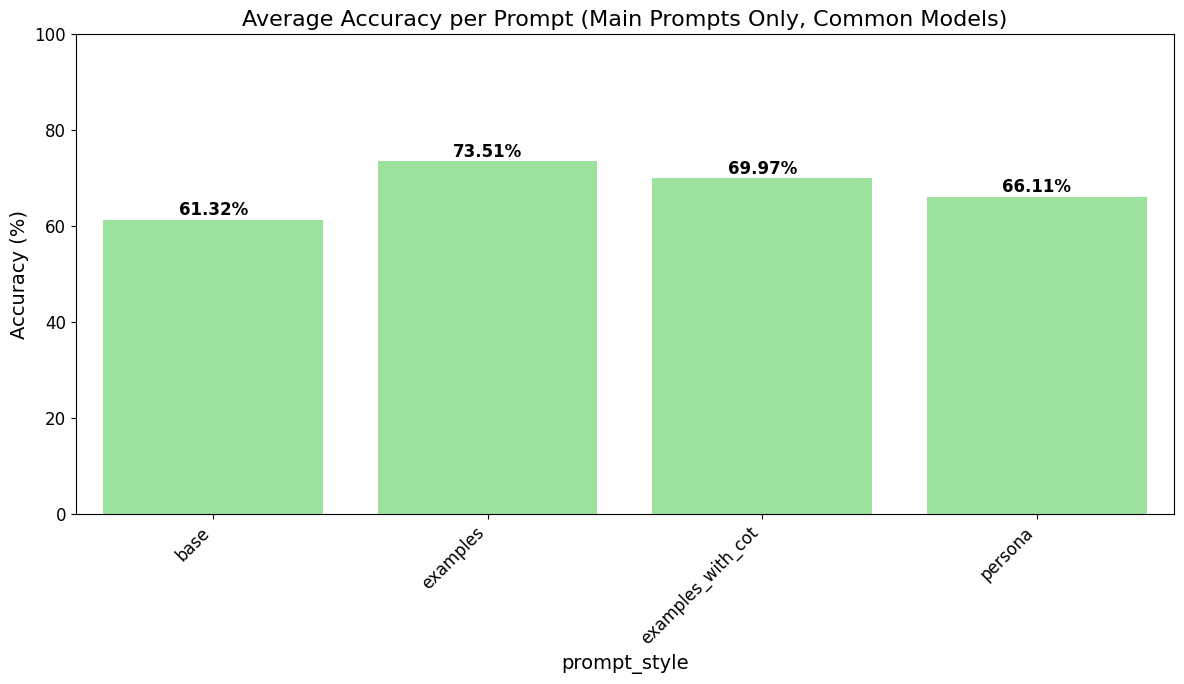

In [134]:
main_prompts = ['base', 'persona', 'examples', 'examples_with_cot']

df_main_prompts = df[df['prompt_style'].isin(main_prompts)]

df_main_prompts = df_main_prompts[df_main_prompts['model'].notna()]

# Find models that exist across all 4 main prompts
models_per_prompt = df_main_prompts.groupby('prompt_style')['model'].unique()

# Find intersection 
common_models = set(models_per_prompt.iloc[0])
for models in models_per_prompt[1:]:
    common_models = common_models.intersection(set(models))

print(f"✅ Common models across main prompts: {sorted(list(common_models))}")

# Filter dataset to only common models and main prompts
df_common = df_main_prompts[df_main_prompts['model'].isin(common_models)]

# Calculate average accuracy per prompt
average_accuracy_per_prompt = df_common.groupby('prompt_style')['is_correct'].mean() * 100

# Corrected plotting code
plt.figure(figsize=(12,7))
sns.barplot(x=average_accuracy_per_prompt.index, y=average_accuracy_per_prompt.values, color="lightgreen")

# Annotate bars
for i, v in enumerate(average_accuracy_per_prompt.values):
    plt.text(i, v + 1, f"{v:.2f}%", ha='center', fontweight='bold')

plt.title('Average Accuracy per Prompt (Main Prompts Only, Common Models)')
plt.ylabel('Accuracy (%)')
plt.ylim(0, 100)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()



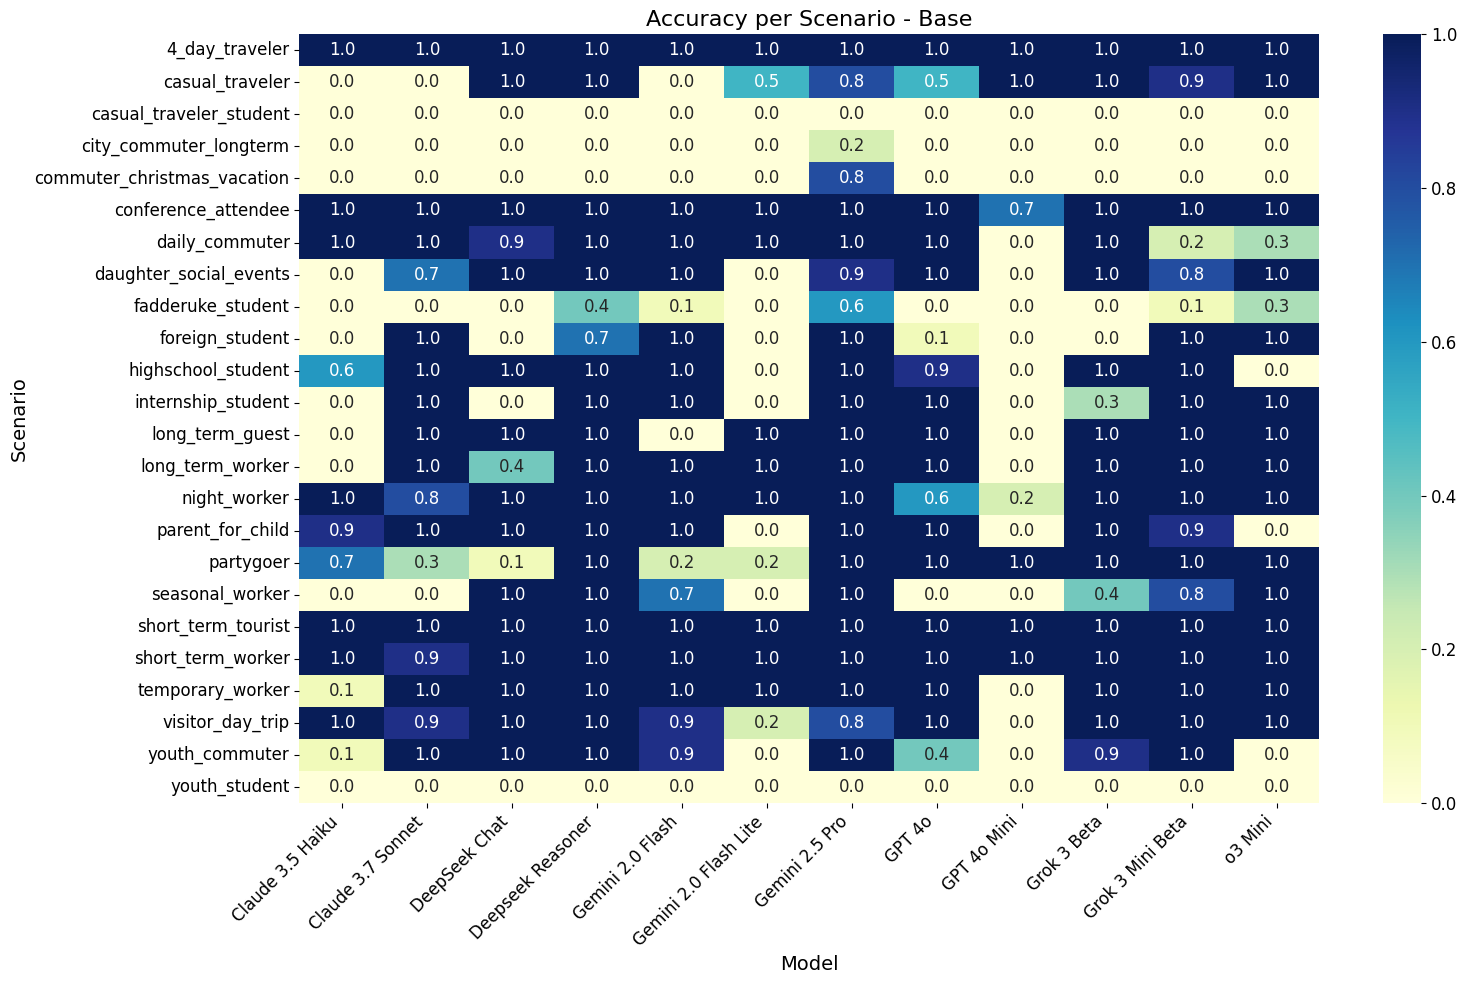

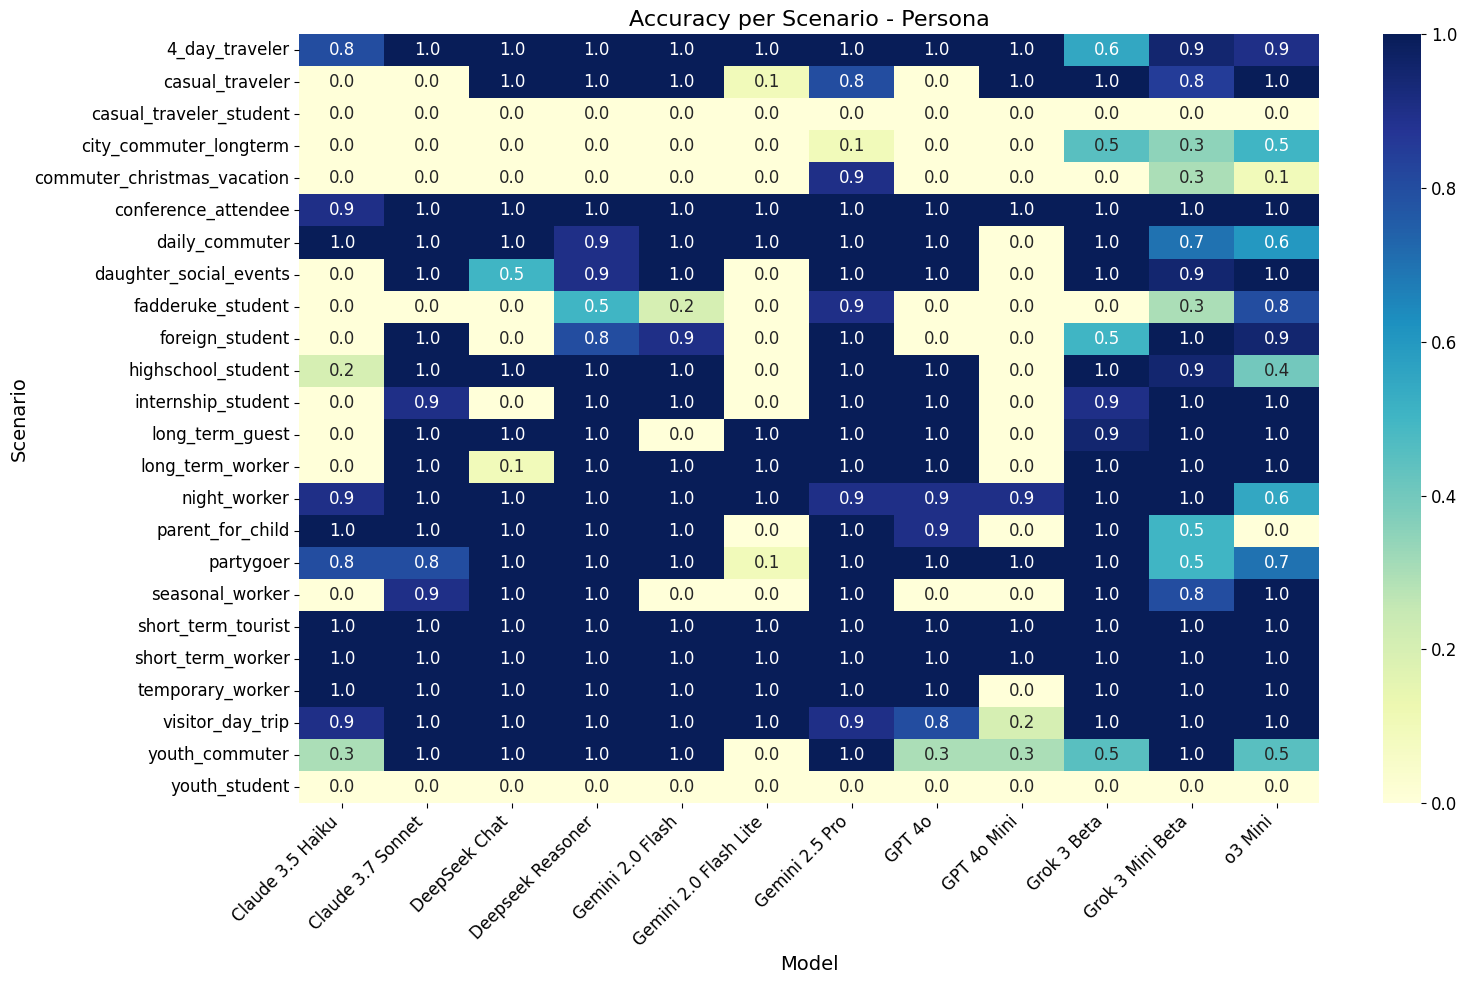

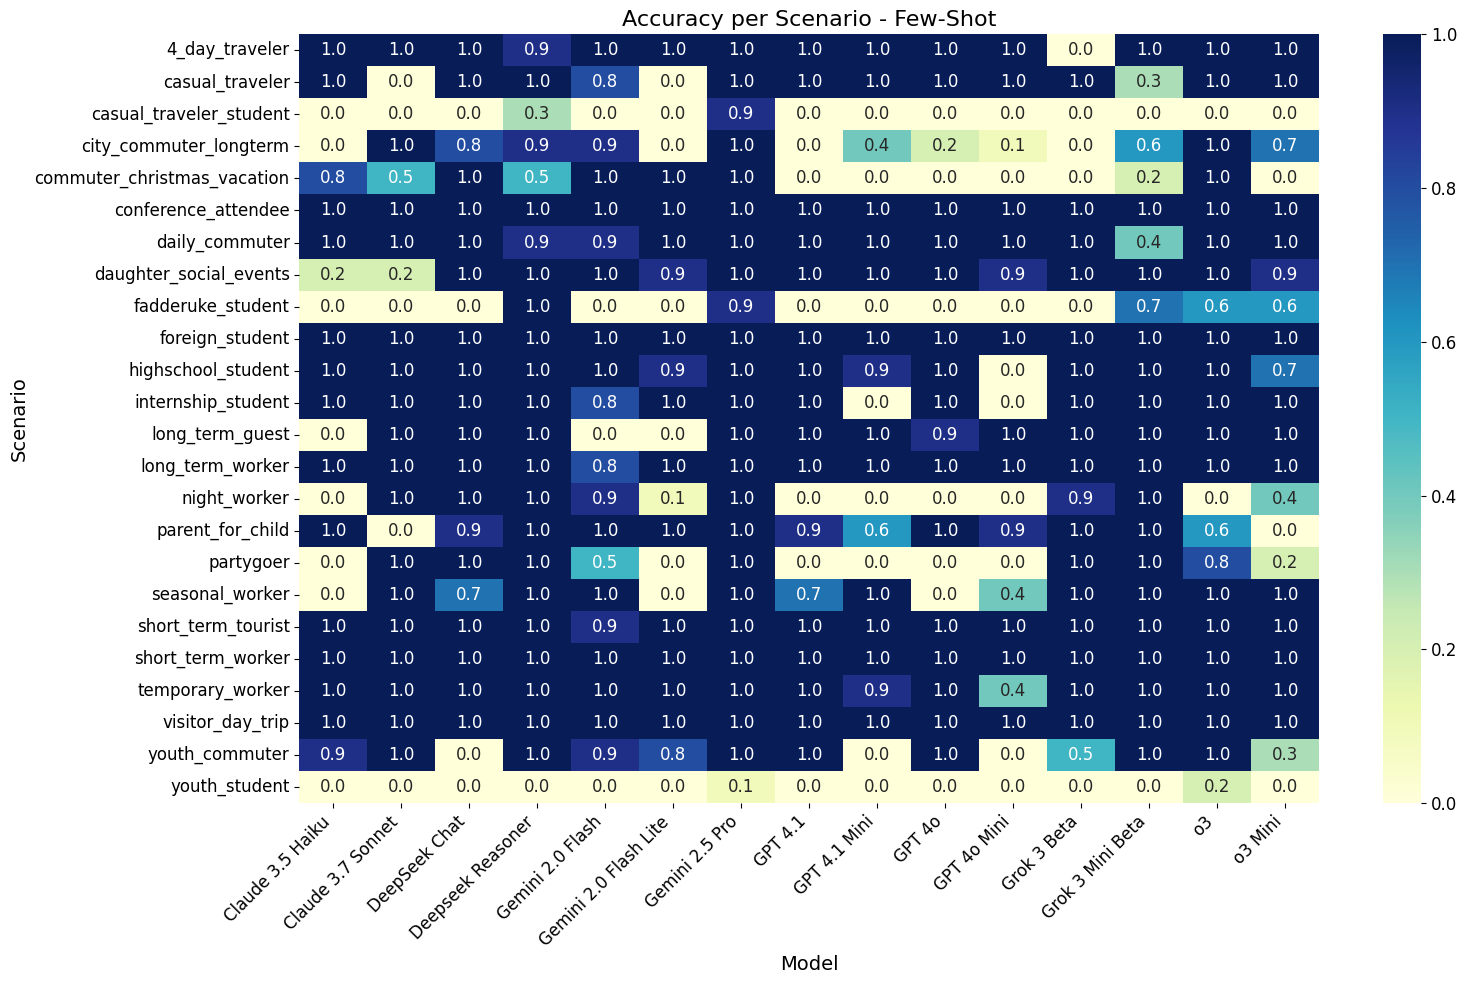

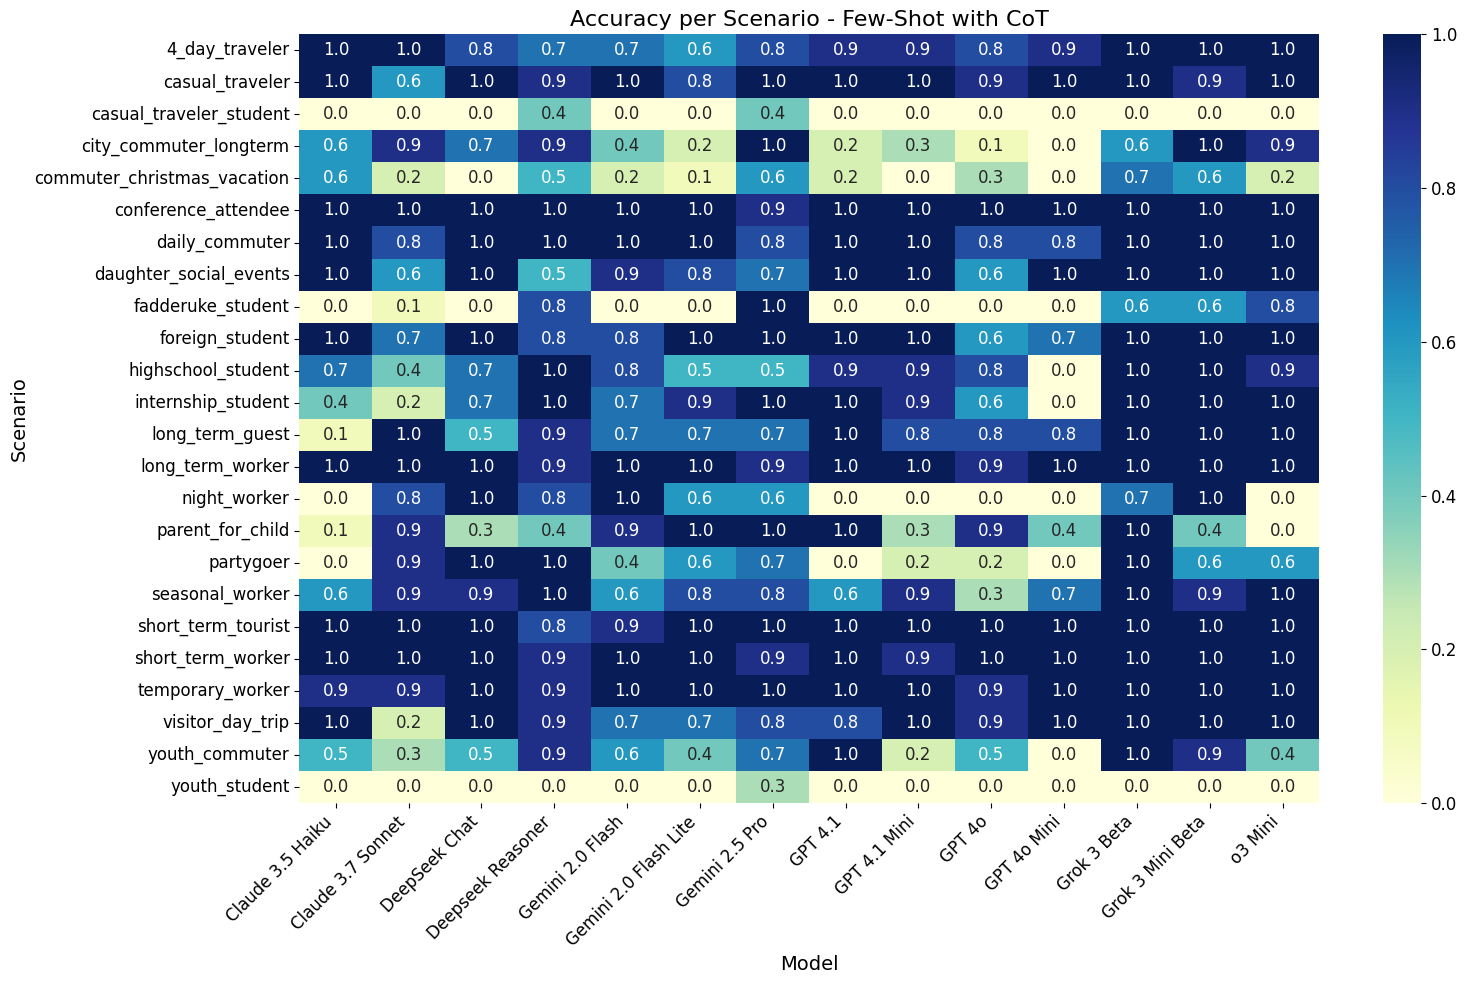

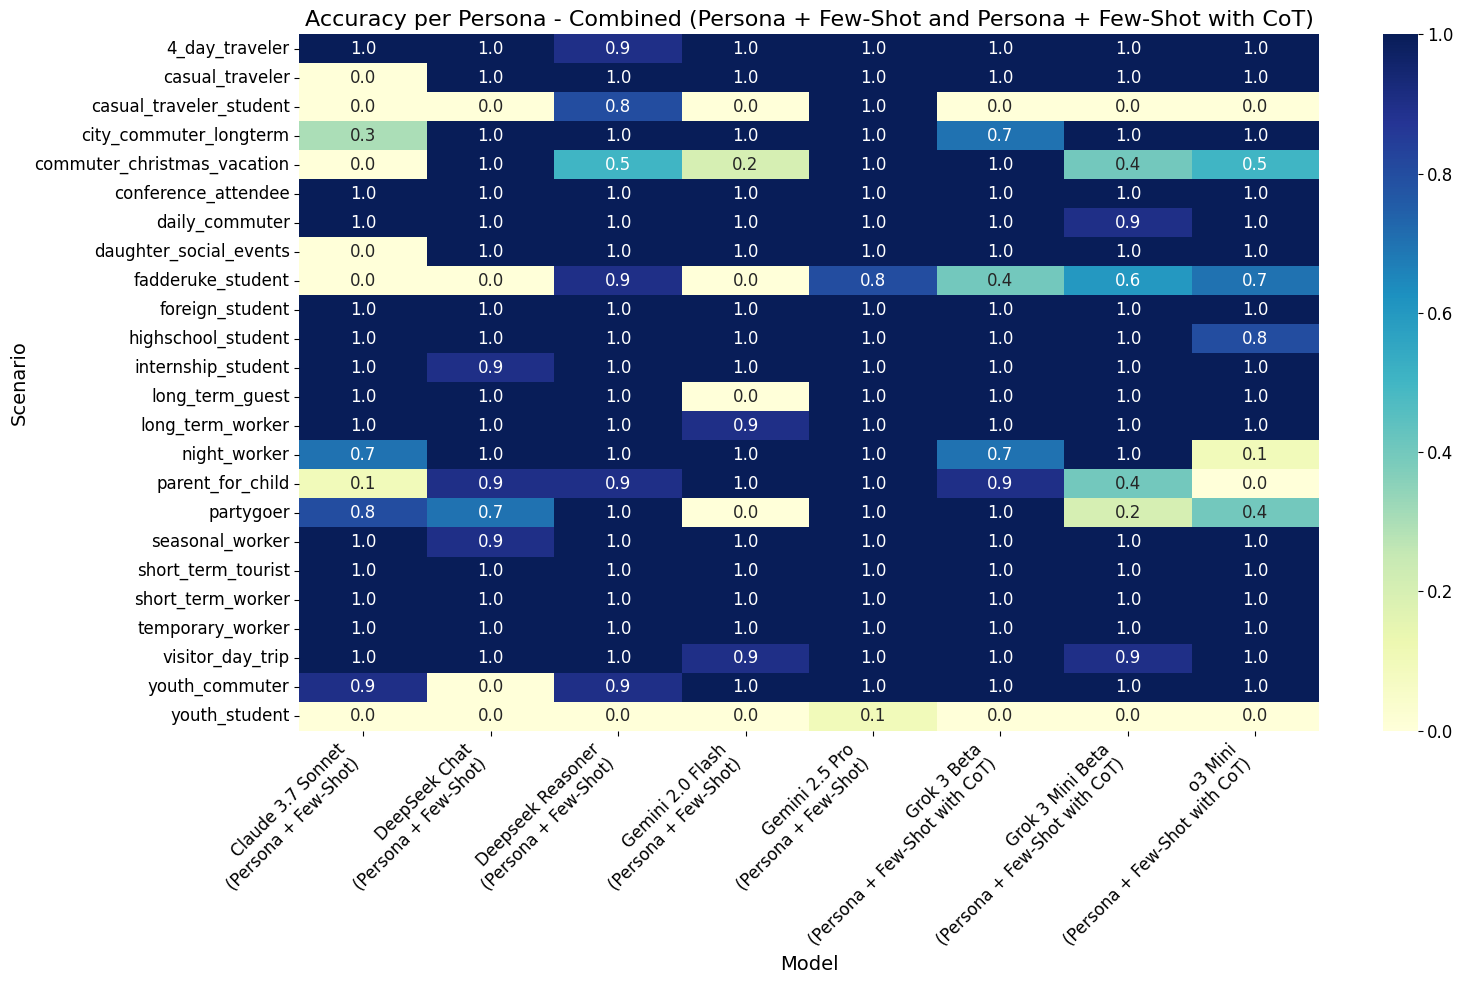

In [144]:
prompt_order = ['base', 'persona', 'examples', 'examples_with_cot', 'persona+examples', 'persona+examples_with_cot']

for prompt_style in prompt_order:
    if prompt_style in ['persona+examples', 'persona+examples_with_cot']:
        # Skip here because we will handle them together later in a separate plot
        continue

    if prompt_style in df['prompt_style'].unique():
        subset = df[df['prompt_style'] == prompt_style]
        pivot = subset.assign(is_correct_numeric=subset['is_correct'].astype(float)).pivot_table(
            index='persona_id', columns='model', values='is_correct_numeric', aggfunc='mean'
        )

        pivot_pretty = pivot.rename(columns=pretty_model_labels)

        plt.figure(figsize=(16,10))
        sns.heatmap(pivot_pretty, annot=True, fmt=".1f", cmap="YlGnBu")
        plt.title(f'Accuracy per Scenario - {pretty_prompt_labels.get(prompt_style, prompt_style)}')
        plt.ylabel('Scenario')
        plt.xlabel('Model')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()

# Now handle the plot for combined styles
combined_styles = ['persona+examples', 'persona+examples_with_cot']
combined_subset = df[df['prompt_style'].isin(combined_styles)].copy()

# Replace model and prompt_style with pretty labels
combined_subset['model_prompt_pretty'] = combined_subset['model'].map(pretty_model_labels).fillna(combined_subset['model']) + \
                                         '\n(' + combined_subset['prompt_style'].map(pretty_prompt_labels).fillna(combined_subset['prompt_style']) + ')'

pivot_combined = combined_subset.assign(is_correct_numeric=combined_subset['is_correct'].astype(float)).pivot_table(
    index='persona_id', columns='model_prompt_pretty', values='is_correct_numeric', aggfunc='mean'
)

plt.figure(figsize=(16, 10))
sns.heatmap(pivot_combined, annot=True, fmt=".1f", cmap="YlGnBu")
plt.title('Accuracy per Persona - Combined (Persona + Few-Shot and Persona + Few-Shot with CoT)')
plt.ylabel('Scenario')
plt.xlabel('Model')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()




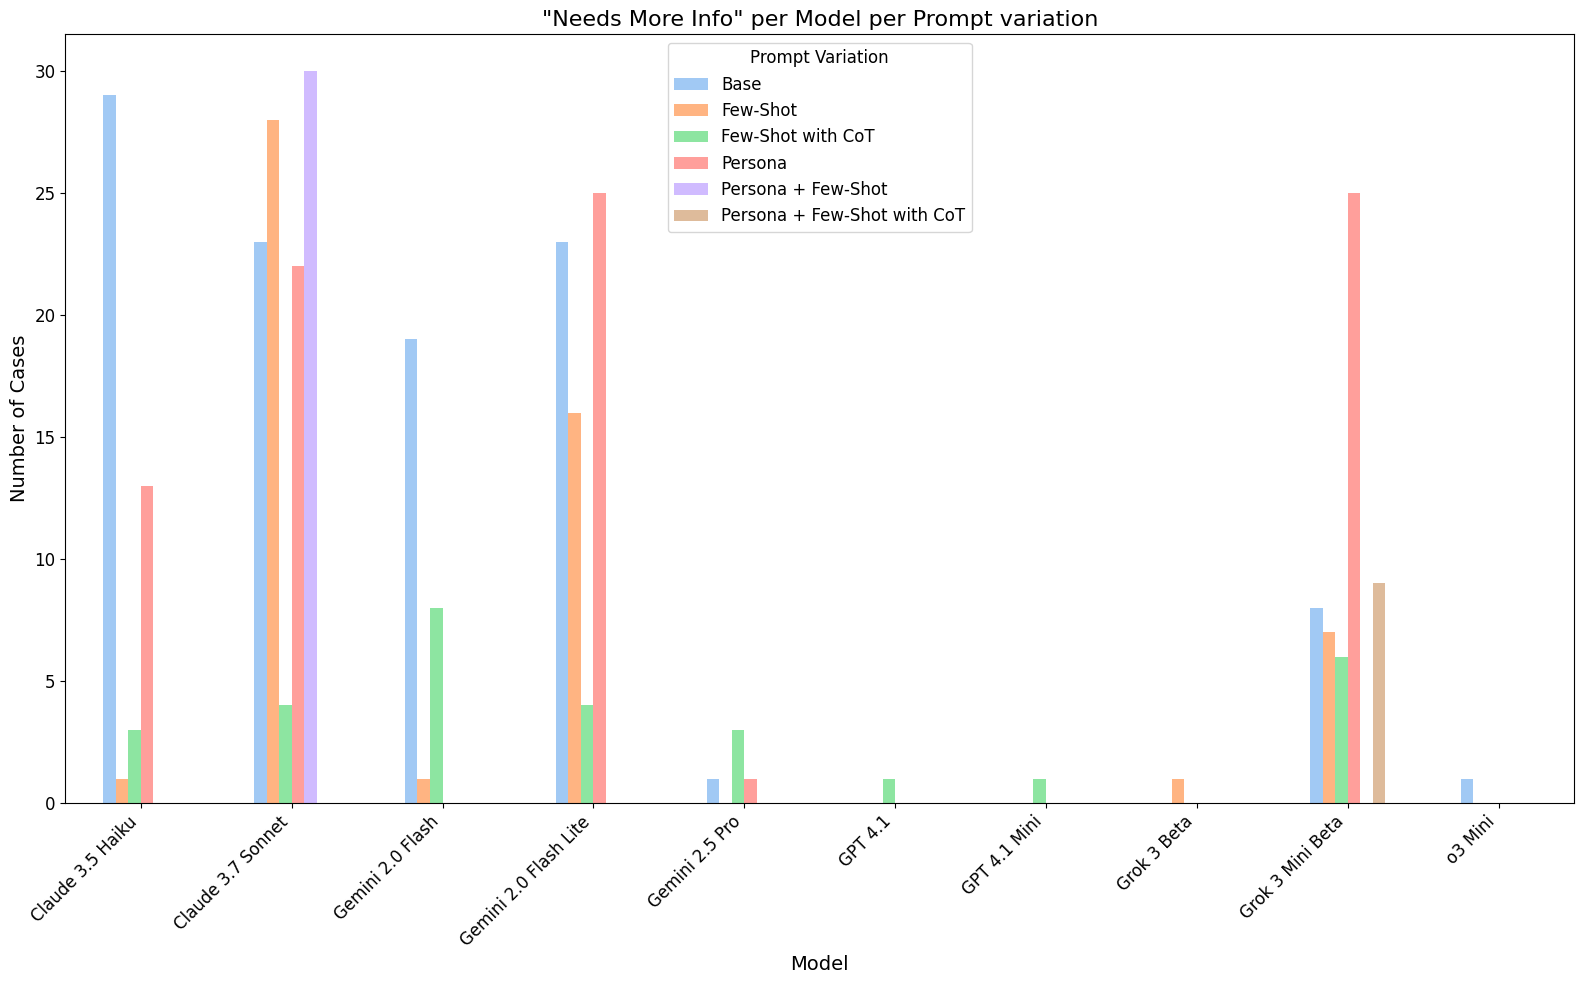

In [148]:
# Filter for entries where the model asked for more information
needs_info_df = df[df['status'] == "need_more_info"]

# Count occurrences grouped by model and prompt style
needs_info_counts = needs_info_df.groupby(['model', 'prompt_style']).size().unstack(fill_value=0)

# Rename model names (index) and prompt styles (columns) for pretty display
needs_info_counts_pretty = needs_info_counts.rename(
    index=pretty_model_labels,
    columns=pretty_prompt_labels
)

# Plot
needs_info_counts_pretty.plot(kind='bar', figsize=(16, 10), color=sns.color_palette("pastel"))
plt.title('"Needs More Info" per Model per Prompt variation')
plt.ylabel('Number of Cases')
plt.xlabel('Model')
plt.legend(title='Prompt Variation')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


<Figure size 1800x1000 with 0 Axes>

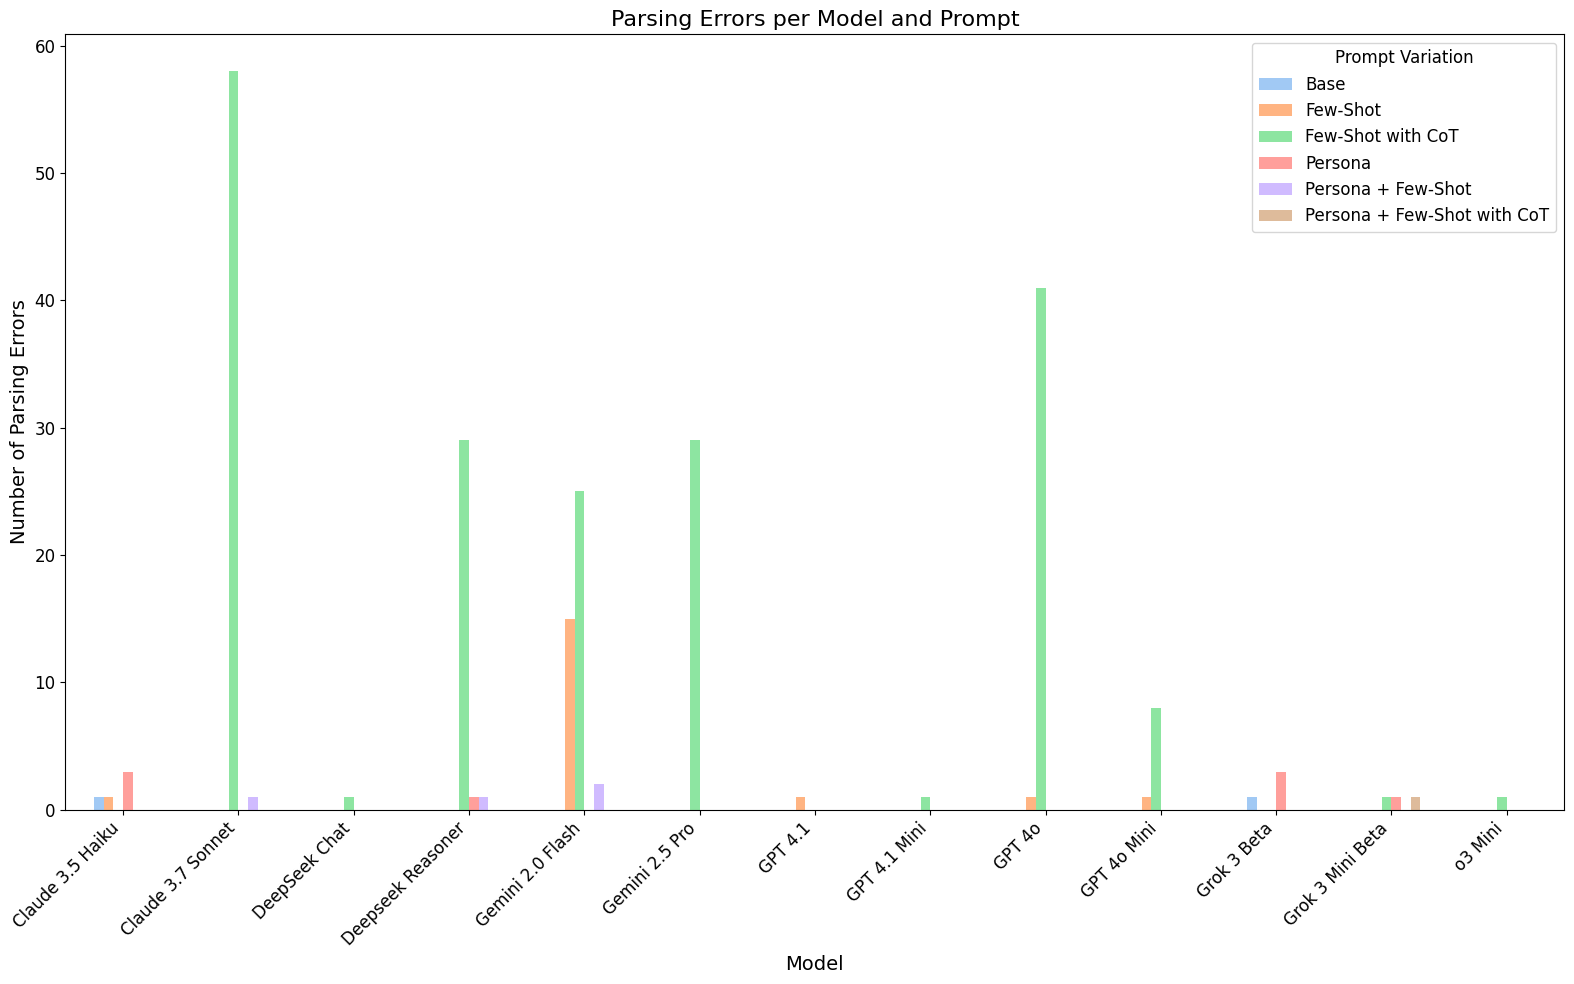

In [149]:
# Prepare data
parsing_errors = df[df['status'] == 'parsing_error']
parsing_error_counts = parsing_errors.groupby(['model', 'prompt_style']).size().unstack(fill_value=0)

# Rename models and prompt styles just for plotting
parsing_error_counts_pretty = parsing_error_counts.rename(
    index=pretty_model_labels,
    columns=pretty_prompt_labels
)

# Plot
plt.figure(figsize=(18, 10))
parsing_error_counts_pretty.plot(kind='bar', figsize=(16, 10), color=sns.color_palette("pastel"))
plt.title('Parsing Errors per Model and Prompt')
plt.ylabel('Number of Parsing Errors')
plt.xlabel('Model')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Prompt Variation')
plt.tight_layout()
plt.show()


In [138]:
import pandas as pd
from langdetect import detect
from langdetect.lang_detect_exception import LangDetectException
import matplotlib.pyplot as plt
import seaborn as sns


FIGSIZE = (16, 8)
COLOR_PALETTE = sns.color_palette("pastel")


# Keep only relevant rows
df_filtered = df[df['status'].isin(['completed', 'need_more_info'])].copy()


def safe_detect_language(row):
    """Safely detect the language of a text string."""
    text = row['text_for_language_check']
    try:
        if isinstance(text, str) and text.strip():
            return detect(text.strip())
        return 'unknown'
    except LangDetectException:
        return 'unknown'

# Prepare text for detection
df_filtered['text_for_language_check'] = None
df_filtered.loc[df_filtered['status'] == 'completed', 'text_for_language_check'] = df_filtered['explanation']
df_filtered.loc[df_filtered['status'] == 'need_more_info', 'text_for_language_check'] = df_filtered['question']

# Detect language
df_filtered['detected_language'] = df_filtered.apply(safe_detect_language, axis=1)
print("✅ Language detection completed.")


✅ Language detection completed.


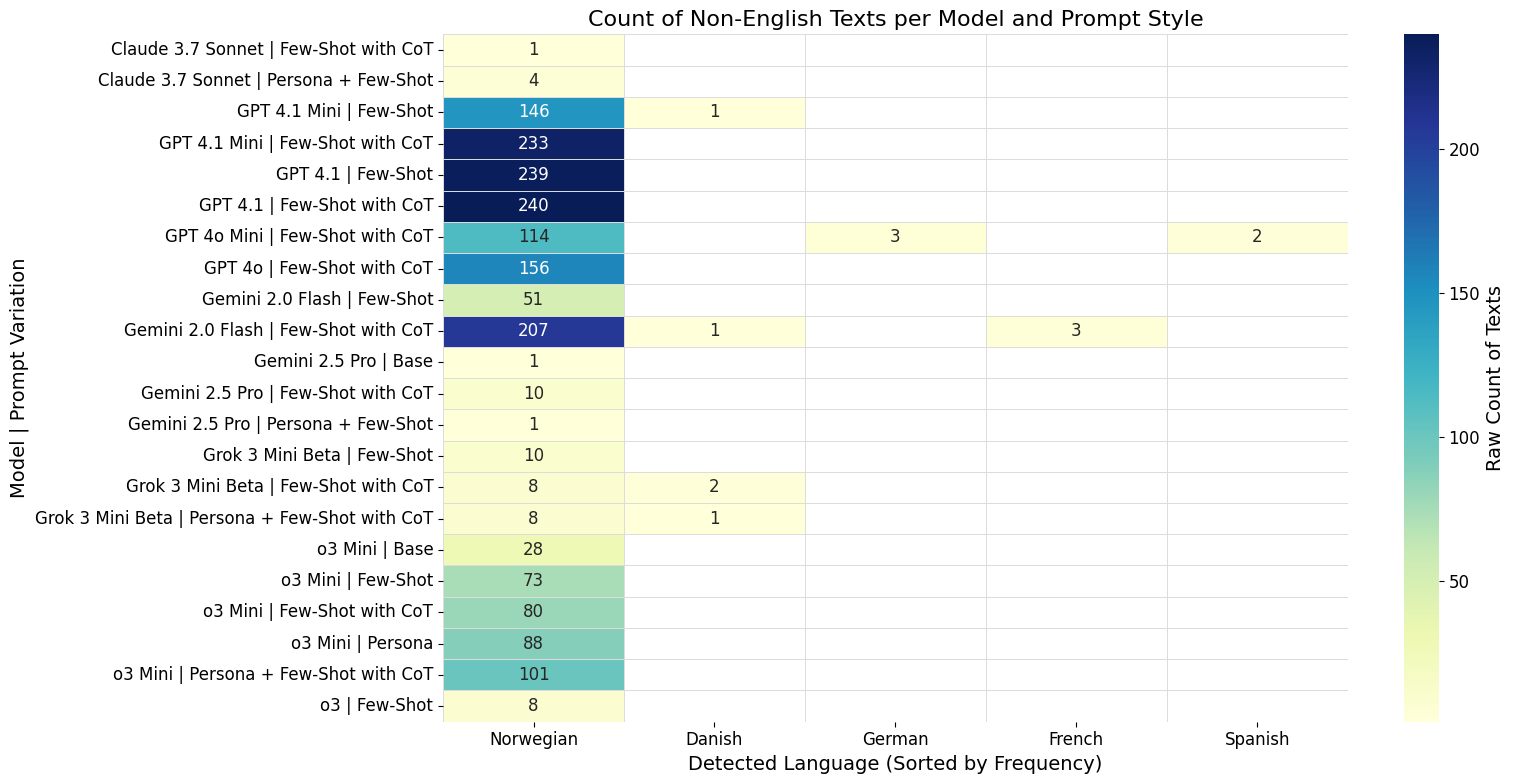

In [139]:
# Count language detections per model/prompt
lang_counts = df_filtered.groupby(['model', 'prompt_style', 'detected_language']).size().reset_index(name='count')

# Remove English and unknown languages
lang_counts = lang_counts[~lang_counts['detected_language'].isin(['en', 'unknown'])]

# Apply pretty labels for model and prompt
lang_counts['model_pretty'] = lang_counts['model'].map(pretty_model_labels).fillna(lang_counts['model'])
lang_counts['prompt_pretty'] = lang_counts['prompt_style'].map(pretty_prompt_labels).fillna(lang_counts['prompt_style'])

# Create combined label
lang_counts['label'] = lang_counts['model_pretty'] + ' | ' + lang_counts['prompt_pretty']

# Pivot table for heatmap
pivot = lang_counts.pivot_table(
    index='label',
    columns='detected_language',
    values='count',
    aggfunc='sum',
    fill_value=0
)

# Sort languages by total count
lang_totals = pivot.sum().sort_values(ascending=False)
pivot = pivot[lang_totals.index]

# Rename language codes for prettier display
language_labels = {
    "no": "Norwegian",
    "da": "Danish",
    "de": "German",
    "fr": "French",
    "es": "Spanish"
}
pivot.rename(columns=language_labels, inplace=True)

# Optional: mask zero values
mask = pivot == 0

# Plot
plt.figure(figsize=FIGSIZE)
sns.heatmap(
    pivot,
    mask=mask,
    annot=True,
    fmt="d",
    cmap="YlGnBu",
    linewidths=0.5,
    linecolor="gainsboro",
    cbar_kws={'label': 'Raw Count of Texts'}
)
plt.title("Count of Non-English Texts per Model and Prompt Style")
plt.xlabel("Detected Language (Sorted by Frequency)")
plt.ylabel("Model | Prompt Variation")
plt.tight_layout()
plt.show()


In [140]:

models_to_include = ["deepseek-chat", "deepseek-reasoner", "gemini-2.5-pro-preview-03-25", "grok-3-mini-beta", "grok-3-beta"]  # Add or remove models as needed
prompt_styles_to_include = ["persona+examples", "persona+examples_with_cot", "examples_with_cot"]  # Adjust as needed

df_filtered = df.dropna(subset=["input_tokens", "output_tokens", "model", "prompt_style"]).copy()
df_filtered["input_tokens"] = df_filtered["input_tokens"].astype(int)
df_filtered["output_tokens"] = df_filtered["output_tokens"].astype(int)
df_filtered["total_tokens"] = df_filtered["input_tokens"] + df_filtered["output_tokens"]

df_filtered = df_filtered[
    df_filtered["model"].isin(models_to_include) &
    df_filtered["prompt_style"].isin(prompt_styles_to_include)
]

summary = (
    df_filtered
    .groupby(["model", "prompt_style"])[["input_tokens", "output_tokens", "total_tokens"]]
    .mean()
    .reset_index()
    .sort_values(["model", "prompt_style"])
)

# Show result
pd.set_option("display.max_rows", 100)
display(summary)


,model,prompt_style,input_tokens,output_tokens,total_tokens
0,deepseek-chat,examples_with_cot,6225.625000,409.866667,6635.491667
1,deepseek-chat,persona+examples,4953.666667,218.287500,5171.954167
2,deepseek-reasoner,examples_with_cot,6227.650000,1115.062500,7342.712500
3,deepseek-reasoner,persona+examples,4955.666667,985.683333,5941.350000
4,gemini-2.5-pro-preview-03-25,examples_with_cot,6664.291667,1622.037500,8286.329167
5,gemini-2.5-pro-preview-03-25,persona+examples,5235.291667,411.737500,5647.029167
6,grok-3-beta,examples_with_cot,6061.041667,749.187500,6810.229167
7,grok-3-beta,persona+examples_with_cot,6132.041667,737.779167,6869.820833
8,grok-3-mini-beta,examples_with_cot,6062.041667,523.045833,6585.087500
9,grok-3-mini-beta,persona+examples_with_cot,6133.041667,502.366667,6635.408333


In [141]:
import pandas as pd

models_to_include = []
prompt_styles_to_include = []

df_time = df.dropna(subset=["model", "prompt_style", "time_used"]).copy()
df_time["time_used"] = df_time["time_used"].astype(float)


avg_times = (
    df_time
    .groupby(["model", "prompt_style"])["time_used"]
    .mean()
    .reset_index()
    .sort_values(["model", "prompt_style"])
    .rename(columns={"time_used": "avg_response_time_sec"})
)

# Show result
pd.set_option("display.max_rows", 100)
display(avg_times)


,model,prompt_style,avg_response_time_sec
0,claude-3-5-haiku-20241022,base,6.074986
1,claude-3-5-haiku-20241022,examples,10.134277
2,claude-3-5-haiku-20241022,examples_with_cot,9.497313
3,claude-3-5-haiku-20241022,persona,9.277678
4,claude-3-7-sonnet-20250219,base,11.099343
5,claude-3-7-sonnet-20250219,examples,7.717912
6,claude-3-7-sonnet-20250219,examples_with_cot,15.719273
7,claude-3-7-sonnet-20250219,persona,11.315999
8,claude-3-7-sonnet-20250219,persona+examples,11.657083
9,deepseek-chat,base,11.247693


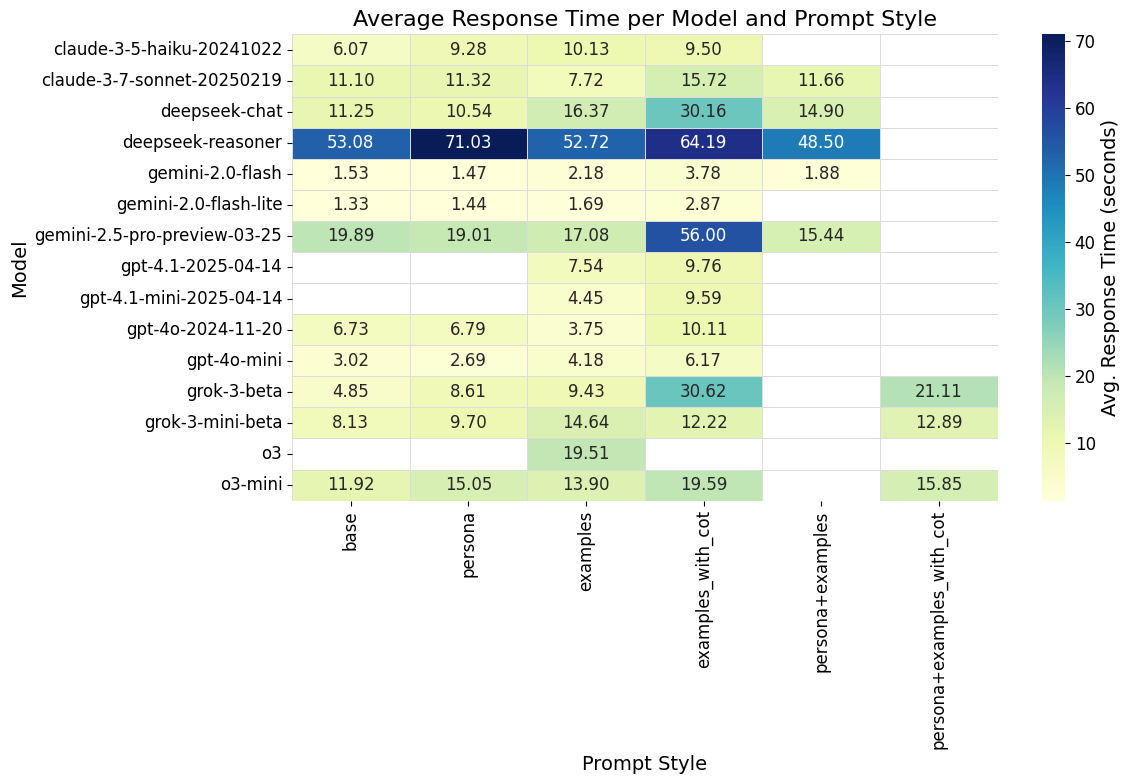

In [142]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

FIGSIZE = (12, 8)
COLORMAP = "YlGnBu"
LINECOLOR = "gainsboro"
LINEWIDTH = 0.5

prompt_order_heatmap = [
    'base',
    'persona',
    'examples',
    'examples_with_cot',
    'persona+examples',
    'persona+examples_with_cot'
]

df_time = df.dropna(subset=["model", "prompt_style", "time_used"]).copy()
df_time["time_used"] = df_time["time_used"].astype(float)

df_time = df_time[
    df_time["model"].isin(df_time["model"].unique()) &
    df_time["prompt_style"].isin(prompt_order_heatmap)
]

avg_times = df_time.groupby(["model", "prompt_style"])["time_used"].mean().reset_index()

pivot = avg_times.pivot_table(
    index="model",
    columns="prompt_style",
    values="time_used",
    aggfunc="mean"
).reindex(columns=prompt_order_heatmap)

plt.figure(figsize=FIGSIZE)
sns.heatmap(
    pivot,
    annot=True,
    fmt=".2f",
    cmap=COLORMAP,
    linewidths=LINEWIDTH,
    linecolor=LINECOLOR,
    cbar_kws={"label": "Avg. Response Time (seconds)"}
)
plt.title("Average Response Time per Model and Prompt Style")
plt.xlabel("Prompt Style")
plt.ylabel("Model")
plt.tight_layout()
plt.show()


In [143]:
# Estimate average token count per model + prompt combination using word count


selected_models = ["deepseek-chat", "deepseek-reasoner", "gemini-2.5-pro-preview-03-25", "grok-3-mini-beta", "grok-3-beta"]  # Add or remove models as needed
selected_prompt_styles = ["persona+examples", "persona+examples_with_cot", "examples_with_cot"]  # Adjust as needed

# Make sure raw is a string and estimate token count using 4 characters per token
df['raw'] = df['raw'].fillna('').astype(str)
df['approx_token_count_raw'] = (df['raw'].str.len() / 4).round(1)

# Filter to the models and prompts you care about
filtered_df = df[df['model'].isin(selected_models) & df['prompt_style'].isin(selected_prompt_styles)]

# Group by model and prompt, compute average token count
avg_token_raw_df = (
    filtered_df
    .groupby(['model', 'prompt_style'])['approx_token_count_raw']
    .mean()
    .reset_index()
    .rename(columns={'approx_token_count_raw': 'avg_token_count_raw_approx'})
    .sort_values(by=['model', 'prompt_style'])
)

avg_token_raw_df

,model,prompt_style,avg_token_count_raw_approx
0,deepseek-chat,examples_with_cot,432.897500
1,deepseek-chat,persona+examples,224.073333
2,deepseek-reasoner,examples_with_cot,421.683750
3,deepseek-reasoner,persona+examples,217.690833
4,gemini-2.5-pro-preview-03-25,examples_with_cot,1463.711667
5,gemini-2.5-pro-preview-03-25,persona+examples,397.234583
6,grok-3-beta,examples_with_cot,820.463333
7,grok-3-beta,persona+examples_with_cot,806.784167
8,grok-3-mini-beta,examples_with_cot,555.090833
9,grok-3-mini-beta,persona+examples_with_cot,532.962917
